## 1 Configurações Iniciais

In [ ]:
# !pip3 install -r requirements.txt

In [1]:
from config import DIRETORIO
from config import DIR_BASE_APLICAT_TRAIN
from config import DIR_BASE_APLICAT_TEST
from config import DIR_BASE_BUREAU
from config import DIR_BASE_BUREAU_BALAN
from config import DIR_BASE_CRED_CARD_BAL
from config import DIR_BASE_INSTAL_PAYAME
from config import DIR_BASE_POS_CASH_BALA
from config import DIR_BASE_PREVIOUS_APP

In [2]:
import matplotlib.pyplot as plt
import pandas            as pd
import numpy             as np
import seaborn           as sn
import warnings

from src.pre_processamento.PreProcessamento import PreProcessamento
from src.modelagem.Modelagem                import Modelagem
from src.modelagem.Testes                   import Testes
from src.pre_processamento.utils            import * 
from src.modelagem.Explicabilidade_Modelos  import *

/home/vitor/anaconda3/envs/env_tcc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)

warnings.filterwarnings("ignore")

In [ ]:
base_train  = pd.read_csv(DIR_BASE_APLICAT_TEST)
base_bureau = pd.read_csv(DIR_BASE_BUREAU) 
base_prev   = pd.read_csv(DIR_BASE_PREVIOUS_APP) 

In [ ]:
base_train.isna().sum()/base_train.shape[0]

In [ ]:
base_train.isna().sum()/base_train.shape[0]

In [ ]:
base_prev['NAME_CONTRACT_TYPE'].value_counts()

In [ ]:
base_prev_variaveis_numeric = create_vars_numeric(base_prev,cols_drop=['SK_ID_CURR','SK_ID_PREV'],remove_null=0.25,prefixo='prev')

In [ ]:
base_prev_variaveis_numeric

In [ ]:
base_bureau_variaveis = create_vars_numeric(base_bureau)

In [ ]:
# SK_ID_CURR
base_train = base_train.merge(base_bureau_variaveis,how='left',on=['SK_ID_CURR'])

In [ ]:
base_train = base_train.merge(base_prev_variaveis_numeric,how='left',on=['SK_ID_CURR'])

In [ ]:
base_treinamento2 = remove_null_over(base_train,over_porc=0.25)

In [ ]:
pre_proce = PreProcessamento(base_treinamento2)

In [ ]:
base_treinamento2 = pre_proce.apply_method_encoding()

In [ ]:
# base_treinamento2['TARGET']=0

In [ ]:
cols_object  = list(base_treinamento2.select_dtypes(include='object').columns)
# base_treinamento3 = pre_proce.padronizacao_dados(base_treinamento2.fillna(-1).drop(cols_object,axis=1))

In [ ]:
base_treinamento2.fillna(-1).drop(cols_object,axis=1).to_csv('base_teste_n_padro.csv',index=False)

In [ ]:
# base_treinamento3.to_csv('data/processed/base_test3.csv',index=False)

In [ ]:
base_treinamento3.head()

### Dados Padronizados

In [ ]:
#base_treinamento3.to_csv('data/processed/base_treinamento3.csv',index=False)

In [4]:
base_teste3 = pd.read_csv('base_teste_n_padro.csv')

In [5]:
base_treinamento3 = pd.read_csv('base_treinamento_n_padro.csv')

In [6]:
def retira_colunas_na(columns):
    return [col for col in columns if 'NA' not in col]

In [7]:
base_teste3['TARGET'] = 0

In [8]:
colunas_selecionar = retira_colunas_na(base_teste3.columns)

In [9]:
base_teste3 = base_teste3[colunas_selecionar]
base_treinamento3 = base_treinamento3[colunas_selecionar]

In [ ]:
base_treinamento3.describe()

In [ ]:
base_teste3.describe()

In [ ]:
pre_proce2 = PreProcessamento(base_treinamento3)
#features = pre_proce2.mutual_information(base_treinamento3.drop(['SK_ID_CURR','TARGET'],axis=1),base_treinamento3[['TARGET']])

In [ ]:
colunas_selecionadas = pre_proce2.correlacao_target(base_treinamento3.drop(['SK_ID_CURR','TARGET'],axis=1),base_treinamento3['TARGET'])

In [ ]:
colunas_selecionadas[0:5]

In [ ]:
colunas_selecionadas = pre_proce2.teste_f_classif(base_treinamento3.drop(['SK_ID_CURR','TARGET'],axis=1),base_treinamento3['TARGET'],50)

In [ ]:
colunas_selecionadas += ['SK_ID_CURR','TARGET']
base_treinamento4 = base_treinamento3[colunas_selecionadas]
base_teste4 = base_teste3[colunas_selecionadas]

In [ ]:
ivs = show_iv(base_treinamento4.fillna(-1))

In [ ]:
correlacao = base_treinamento3[['TARGET', 'prev_AMT_ANNUITY_mean','prev_AMT_ANNUITY_max','prev_AMT_CREDIT_mean','prev_AMT_GOODS_PRICE_mean','prev_DAYS_DECISION_mean','_AMT_CREDIT_SUM_OVERDUE_max']].corr()

In [ ]:
correlacao2 = base_treinamento2[['TARGET']+ vars_bureau[20:]].corr()

In [ ]:
import seaborn as sn
sn.heatmap(correlacao, annot = True, fmt=".1f", linewidths=.6)

In [ ]:
sn.heatmap(correlacao2, annot = True, fmt=".1f", linewidths=.6)

In [ ]:
pre_proce2.check_outliers(base_treinamento4,colunas_selecionadas)

In [ ]:
modelo_kmeans = Modelagem(base_treinamento3.fillna(-1),'TARGET')

In [ ]:
modelo_kmeans.evaluate_values_of_k(5)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2)
kmeans.fit(base_treinamento3.drop('TARGET',axis=1).fillna(-1))

In [ ]:
base_treinamento3['cluster'] = kmeans.labels_

In [ ]:
base_treinamento3.query('TARGET==1').shape[0]

In [ ]:
base_treinamento3.query('TARGET==1')['cluster'].value_counts()/base_treinamento3.shape[0]

In [ ]:
base_treinamento3['cluster'].value_counts(normalize=True)

In [10]:
def manter_alnum(s):
    return ''.join(e for e in s if e.isalnum() or e=='_')
# Aplica a função aos nomes das colunas
base_treinamento3.columns = [manter_alnum(col) for col in base_treinamento3.columns]
base_teste3.columns = [manter_alnum(col) for col in base_teste3.columns]
# base_treinamento4.columns = [manter_alnum(col) for col in base_treinamento4.columns]
# base_teste4.columns = [manter_alnum(col) for col in base_teste4.columns]

parametros = {
    # 'objective': ['binary'],
    # 'boosting_type': ['rf'],
    'min_data_in_leaf':[500,1000,2000],
    # 'reg_alpha':20,
    # 'reg_lambda':18,
    'num_leaves': [10,50,100],
    'max_depth':[5,10,15],
    'n_estimators':[50,100],
    'learning_rate': [0.01],
    'feature_fraction': [0.7],
    'num_iterations':[100],
    # 'class_weight':['balanced'],
    # 'n_jobs':[5],
    # 'random_state' : [0]
}
parametros = {'n_estimators': 259, 'max_depth': 10, 'learning_rate': 0.24030389094746216, 'num_leaves': 100, 'min_data_in_leaf': 789, 'num_iterations': 57,'feature_fraction': 0.7,'random_state':42,'boosting_type':'rf','class_weight' : 'balanced','reg_alpha': 0}

In [ ]:
modelos_testes = {}
parametros_otimizar_lgbm = [
    ['n_estimators','int',25,200],
    ['max_depth','int',5,50],
    ['learning_rate','float',0.001, 0.2],
    ['num_leaves','int',50, 200],
    ['min_data_in_leaf','int',500, 3000],
    ['num_iterations','int',100, 1000],
    ['feature_fraction','float',0.3, 1],
    ['class_weight','fixo','balanced', None],
    ['objective','fixo','binary', None],
    ['boosting_type','str','rf', 'gbdt'],
    ['metric','fixo','auc', None],
    ['verbose','fixo',-1, None]
]
# model_lgbm.set_model('lgb',{'random_state':42})
parametros_otimizar_xgboosting = [
    ['n_estimators','int',25,1000],
    ['max_depth','int',5,50],
    ['learning_rate','float',0.001, 0.2],
    ['min_child_weight','int',500, 3000],
    ['subsample','float',0.2, 0.9],
    ['colsample_bytree','float',0.25, 1],
    ['colsample_bytree','float',0.25, 1],
    ['eval_metric','fixo','auc', None]
    
]
# model_xgbosting.set_model('xgboost',{'random_state':42})

In [ ]:
# modelos_testes['lgb'] = parametros_otimizar_lgbm
modelos_testes['xgboost'] = parametros_otimizar_xgboosting

In [ ]:
modelos_testes

In [11]:
colunas_selecionar = base_treinamento3.drop(['SK_ID_CURR','TARGET'],axis=1).columns

In [ ]:
testando_modelos = Testes(modelos_testes,base_treinamento3,colunas_selecionar)

In [ ]:
testando_modelos.executa_simulações(qtd_it_features =10,qtd_iteracoes=50,seletor_features=['anova'])

In [12]:
parametros_lgb_50f_anova = {
    'n_estimators': 67,
    'max_depth': 11,
    'learning_rate': 0.027210530118485614,
    'num_leaves': 143,
    'min_data_in_leaf': 2447,
    'num_iterations': 716,
    'feature_fraction': 0.6250966328796074,
    'boosting_type': 'gbdt',
    'verbose':-1,
    'metric':'auc',
    'objective':'binary',
    'class_weight':'balanced',
    'random_state':42
}

In [13]:
pre_proce = PreProcessamento(base_treinamento3[colunas_selecionar])
cols_anova = pre_proce.teste_f_classif(base_treinamento3[colunas_selecionar],base_treinamento3['TARGET'])
cols_anova = cols_anova[0:50]
cols_anova += ['SK_ID_CURR','TARGET']

In [14]:
model_lgbm = Modelagem(base_treinamento3[cols_anova].drop('SK_ID_CURR',axis=1),'TARGET')

In [15]:
model_lgbm.set_model('lgb',parametros_lgb_50f_anova)
model_lgbm.train_model()

Reporte de Classificação para o Treino:
A AUC ROC DO TREINO FOI >>> 0.8304344964453031


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [16]:
exp_model = Explicabilidade_Modelos(model_lgbm.model)
exp_model.set_data(model_lgbm.X_train,model_lgbm.y_train,tipo_dado='')

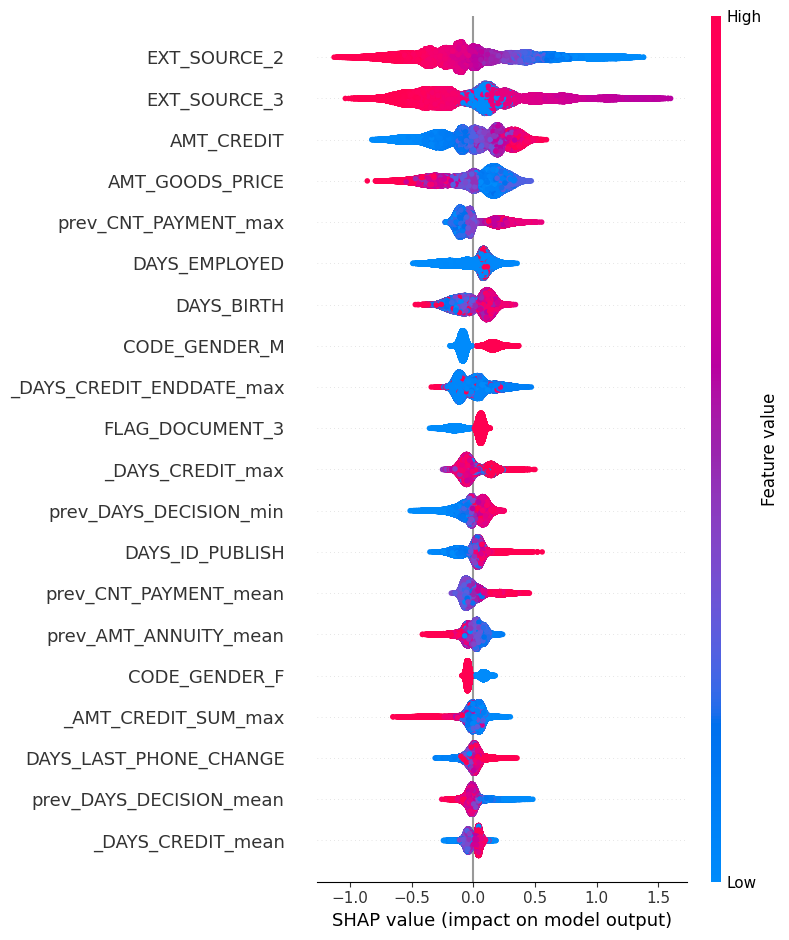

In [18]:
exp_model.grafico_summary_plot(tipo_dado='')

In [23]:
exp_model.grafico_dependence_plot('EXT_SOURCE_2',tipo_dado='')

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
study_lgbm,melhores_param_lgbm = model_lgbm.otimizacao_parametros_optuna(parametros_otimizar_lgbm,num_iteracoes=1000)

In [ ]:
import optuna
optuna.visualization.plot_param_importances(study_lgbm)

In [ ]:
melhores_param_lgbm['metric']        = 'auc'
melhores_param_lgbm['random_state']  = 42
#melhores_param_lgbm['boosting_type'] = 'rf'
melhores_param_lgbm['objective']     = 'binary'
melhores_param_lgbm['class_weight']  = 'balanced'
melhores_param_lgbm

In [ ]:
model_lgbm.set_model('lgb',melhores_param_lgbm)
model_lgbm.train_model()

In [ ]:
import shap

In [ ]:
model_lgbm

In [ ]:
base_teste4['TARGET'] = model_lgbm.model.predict_proba(base_teste4.drop(['SK_ID_CURR','TARGET'],axis=1))[:, 1]

In [ ]:
base_teste4[['SK_ID_CURR','TARGET']].to_csv('envio_model_lgbm_50f_N_P_GBDT.csv',index=False)

In [ ]:
parametros_otimizar_xgboosting = [
    ['n_estimators','int',25,1000],
    ['max_depth','int',5,50],
    ['learning_rate','float',0.001, 0.2],
    ['min_child_weight','int',500, 3000],
    ['subsample','float',0.2, 0.9],
    ['colsample_bytree','float',0.25, 1],
    ['colsample_bytree','float',0.25, 1],
    ['eval_metric','fixo','auc', None],
]
model_xgbosting.set_model('xgboost',{'random_state':42})

In [ ]:
study_xgb,melhores_param_xgb = model_xgbosting.otimizacao_parametros_optuna(parametros_otimizar_xgboosting,num_iteracoes=100)

In [ ]:
# melhores_param_xgb['eval_metric'] = 'auc'
# melhores_param_xgb['random_state'] = 42
melhores_param_xgb = {'n_estimators': 970,
 'max_depth': 18,
 'learning_rate': 0.22589169992824773,
 'min_child_weight': 719,
 'subsample': 0.8356876344182604,
 'colsample_bytree': 0.5516631473198319,
 'eval_metric': 'auc',
 'random_state': 42}

In [ ]:
model_xgbosting.set_model('xgboost',melhores_param_xgb)
model_xgbosting.train_model()